In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

np.set_printoptions(precision = 3, suppress = True)

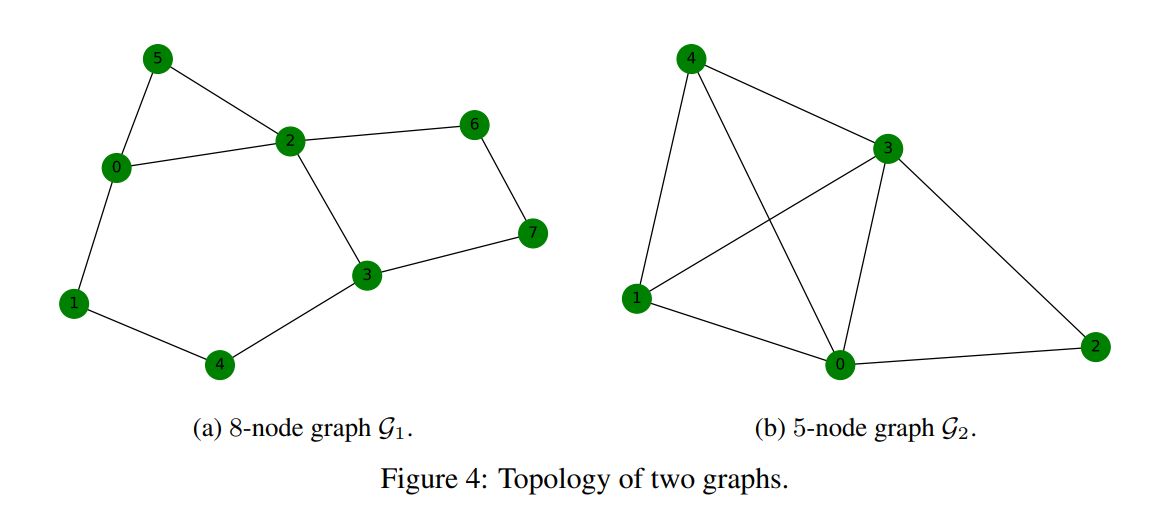

In [2]:
# Define Graphs

G1 = np.zeros((8, 8))
edges = [[0, 1], [1, 4], [4, 3], [3, 2], [2, 0], [5, 0], [5, 2], [6, 2], [6, 7], [7, 3]]
for edge in edges:
    u, v = edge
    G1[u][v] = 1
    G1[v][u] = 1

G2 = np.zeros((5, 5))
edges = [[0, 1], [0, 2], [0, 3], [0, 4], [1, 3], [1, 4], [2, 3], [3, 4]]
for edge in edges:
    u, v = edge
    G2[u][v] = 1
    G2[v][u] = 1

MHRW

In [4]:
# MHRW 

def MHRW(graph):
    nodes = graph.shape[0]
    P = np.zeros((nodes, nodes))
    for i in range(nodes):
        for j in range(nodes):
            if i != j and graph[i][j] == 1:
                di = np.sum(graph[i])
                dj = np.sum(graph[j])
                P[i][j] = min(1/di, 1/dj)
    
    for i in range(nodes):
        P[i][i] = 1 - np.sum(P[i])

    return P

Modified MHRW

Modify MHRW such that self transition probabilities are minimal while ensuring matrix is doubly stochastic

In [5]:
def modified_MHRW(graph):
    nodes = graph.shape[0]
    D = cp.Variable((nodes, nodes))
    P = cp.Constant(MHRW(graph))
    I = np.identity(nodes)
    objective = cp.Minimize(cp.norm((P + D)*I))
    O = np.ones((nodes, 1))
    constraints = [(P + D)*O == O, (O.T)*(P + D) == O.T]
    for i in range(nodes):
        for j in range(nodes):
            if graph[i][j] == 0 and i != j:
                constraints.append(D[i][j] == 0)
    prob = cp.Problem(objective,constraints)
    prob.solve()
    # print('status: %s.'%prob.status,'optimal value=%.6f'%prob.value)
    return (P + D).value

FMMC

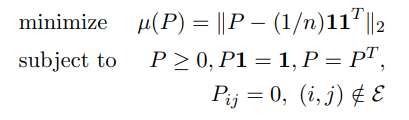

In [6]:
# FMMC

def FMMC(graph):
    nodes = graph.shape[0]
    P = cp.Variable((nodes, nodes))
    I = np.ones(nodes)
    objective= cp.Minimize(cp.norm(P-1.0/nodes))
    constraints = [P>=0, P*I==I, P.T==P]
    # print(graph)
    for i in range(nodes):
        for j in range(nodes):
            if graph[i][j] == 0 and i != j:
                constraints.append(P[i][j] == 0)
    prob = cp.Problem(objective,constraints)
    prob.solve()
    # print('status: %s.'%prob.status,'optimal value=%.6f'%prob.value)
    return P.value

In [7]:
# Perform SGD

def loss(theta, b):
    n = len(b)
    return np.sum((b - theta)**2)/(2*n)

def SGD(b, P):
    t = 1
    theta = 0.0
    nodes = P.shape[0]
    losses = []
    node = np.random.randint(0, nodes - 1)
    CDF = np.cumsum(P, axis = 1)
    while t <= 15:
        # Perform step of SGD
        gamma = 1/t**(0.9)
        theta = theta - gamma*(theta - b[node])

        # Compute loss
        # losses.append(loss(theta, b))
        losses.append((theta - np.mean(b))**2)
        
        # Move to next state
        rand_val = np.random.uniform()
        next = 0
        # print(rand_val, node)
        while rand_val >= CDF[node][next]:
            next += 1
        node = next
        t += 1

    return theta, losses


In [9]:
def run_trails(P, b, num_trails = 100000):

    t = []
    losses = []
    for trails in range(num_trails):
        x, y = SGD(b, P)
        t.append(x)
        losses.append(y)
    theta = np.mean(t)
    losses = np.array(losses)
    losses = np.mean(losses, axis = 0)

    return theta, losses

Graph G1

In [10]:
P1 = MHRW(G1)
P1

array([[0.083, 0.333, 0.25 , 0.   , 0.   , 0.333, 0.   , 0.   ],
       [0.333, 0.167, 0.   , 0.   , 0.5  , 0.   , 0.   , 0.   ],
       [0.25 , 0.   , 0.   , 0.25 , 0.   , 0.25 , 0.25 , 0.   ],
       [0.   , 0.   , 0.25 , 0.083, 0.333, 0.   , 0.   , 0.333],
       [0.   , 0.5  , 0.   , 0.333, 0.167, 0.   , 0.   , 0.   ],
       [0.333, 0.   , 0.25 , 0.   , 0.   , 0.417, 0.   , 0.   ],
       [0.   , 0.   , 0.25 , 0.   , 0.   , 0.   , 0.25 , 0.5  ],
       [0.   , 0.   , 0.   , 0.333, 0.   , 0.   , 0.5  , 0.167]])

In [11]:
P2 = modified_MHRW(G1)
P2[P2 < 1e-8] = 0
P2

/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dis

array([[0.   , 0.44 , 0.34 , 0.   , 0.   , 0.37 , 0.   , 0.   ],
       [0.44 , 0.071, 0.   , 0.   , 0.489, 0.   , 0.   , 0.   ],
       [0.34 , 0.   , 0.   , 0.089, 0.   , 0.398, 0.536, 0.   ],
       [0.   , 0.   , 0.089, 0.   , 0.549, 0.   , 0.   , 0.488],
       [0.   , 0.489, 0.   , 0.549, 0.   , 0.   , 0.   , 0.   ],
       [0.37 , 0.   , 0.398, 0.   , 0.   , 0.232, 0.   , 0.   ],
       [0.   , 0.   , 0.536, 0.   , 0.   , 0.   , 0.206, 0.258],
       [0.   , 0.   , 0.   , 0.488, 0.   , 0.   , 0.258, 0.255]])

In [12]:
P3 = FMMC(G1)
P3[P3 < 1e-8] = 0
P3

/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


array([[0.132, 0.415, 0.174, 0.   , 0.   , 0.279, 0.   , 0.   ],
       [0.415, 0.096, 0.   , 0.   , 0.489, 0.   , 0.   , 0.   ],
       [0.174, 0.   , 0.   , 0.061, 0.   , 0.319, 0.446, 0.   ],
       [0.   , 0.   , 0.061, 0.144, 0.464, 0.   , 0.   , 0.332],
       [0.   , 0.489, 0.   , 0.464, 0.047, 0.   , 0.   , 0.   ],
       [0.279, 0.   , 0.319, 0.   , 0.   , 0.402, 0.   , 0.   ],
       [0.   , 0.   , 0.446, 0.   , 0.   , 0.   , 0.091, 0.463],
       [0.   , 0.   , 0.   , 0.332, 0.   , 0.   , 0.463, 0.205]])

In [19]:
b = np.random.uniform(size = 8)
b

array([0.56 , 0.764, 0.68 , 0.779, 0.707, 0.274, 0.386, 0.66 ])

In [20]:
_, l1 = run_trails(P1, b)
_, l2 = run_trails(P2, b)
_, l3 = run_trails(P3, b)

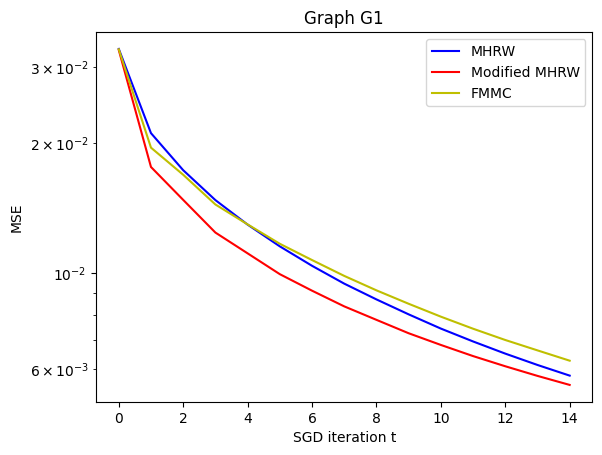

In [21]:
plt.figure()
plt.yscale("log")
plt.plot(l1, c = 'b', label = "MHRW")
plt.plot(l2, c = 'r', label = "Modified MHRW")
plt.plot(l3, c = 'y', label = "FMMC")
plt.legend()
plt.title("Graph G1")
plt.xlabel("SGD iteration t")
plt.ylabel("MSE")
plt.show()

Graph G2

In [22]:
Q1 = MHRW(G2)
Q1

array([[0.   , 0.25 , 0.25 , 0.25 , 0.25 ],
       [0.25 , 0.167, 0.   , 0.25 , 0.333],
       [0.25 , 0.   , 0.5  , 0.25 , 0.   ],
       [0.25 , 0.25 , 0.25 , 0.   , 0.25 ],
       [0.25 , 0.333, 0.   , 0.25 , 0.167]])

In [23]:
Q2 = modified_MHRW(G2)
Q2[Q2 < 1e-8] = 0
Q2

/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dis

array([[0.   , 0.303, 0.404, 0.   , 0.303],
       [0.303, 0.197, 0.   , 0.303, 0.197],
       [0.404, 0.   , 0.192, 0.404, 0.   ],
       [0.   , 0.303, 0.404, 0.   , 0.303],
       [0.303, 0.197, 0.   , 0.303, 0.197]])

In [24]:
Q3 = FMMC(G2)
Q3[Q3 < 1e-8] = 0
Q3

/usr/local/lib/python3.9/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)


array([[0.083, 0.25 , 0.333, 0.083, 0.25 ],
       [0.25 , 0.25 , 0.   , 0.25 , 0.25 ],
       [0.333, 0.   , 0.333, 0.333, 0.   ],
       [0.083, 0.25 , 0.333, 0.083, 0.25 ],
       [0.25 , 0.25 , 0.   , 0.25 , 0.25 ]])

In [25]:
b = np.random.uniform(size = 5)
b

array([0.052, 0.689, 0.815, 0.15 , 0.649])

In [30]:
_, e1 = run_trails(Q1, b)
_, e2 = run_trails(Q2, b)
_, e3 = run_trails(Q3, b)

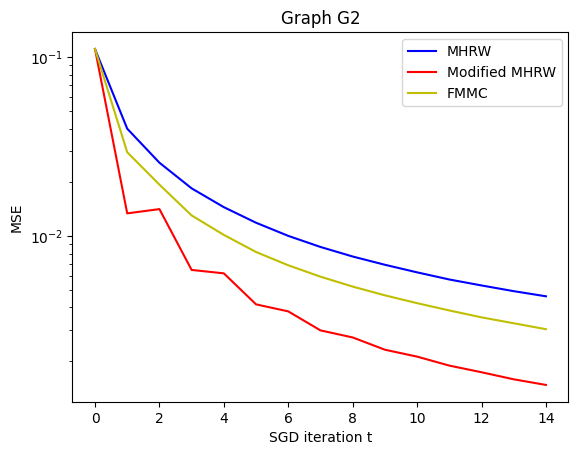

In [31]:
plt.figure()
plt.yscale("log")
plt.plot(e1, c = 'b', label = "MHRW")
plt.plot(e2, c = 'r', label = "Modified MHRW")
plt.plot(e3, c = 'y', label = "FMMC")
plt.legend()
plt.title("Graph G2")
plt.xlabel("SGD iteration t")
plt.ylabel("MSE")
plt.show()